# Simulação de filas MMm

## Filas MMm
O sistema possui  servidores e uma fila de espera de tamanho infinito.<br><br>
As tarefas chegam segundo um processos de Poisson com taxa $\lambda$, ou seja, o tempo médio decorrido entre duas chegadas consecutivas (variável $T$) tem distribuição exponencial com média $\frac{1}{\lambda}$.<br><br>
A taxa de serviço em cada servidor é $\mu$, ou seja, o tempo de serviço para cada tarefa (variável $S$) tem distribuição exponencial com media $\frac{1}{\mu}$.<br><br>
A variável $R$ representa o tempo de resposta do sistema, ou seja, o tempo decorrido desde a chegada no sistema até a saída do mesmo.<br><br>
A variável $W$ representa o tempo de espera na fila, ou seja, o tempo que uma tafefa permanece esperando na fila.<br><br>
A variável $N$ representa a quantidade de tarefas dentro do sistema.<br><br>
A variável $N_{q}$ representa a quantidade de tarefas na fila.<br><br>
A variável $N_{s}$ representa a quantidade de tarefas sendo servidas.<br><br>
Os parâmetros do sistema são:
* Quantidade de servidores: $m$
* Taxa de chegada: $\lambda$
* Taxa de serviço: $\mu$
* Quantidade de eventos simulados: $nsim$
* A taxa de chegada precisa ser menor do que a taxa de serviço ($\lambda < m*\mu$)

## Classe Engine MMm
A classe **engineMMm** implementa a simulação de filas MMm.<br><br>
Argumentos do contrutor: taxa de chegadas $\lambda$, a taxa de serviço de cada servidor $\mu$, a quantidade de servidores $m$ e flag para trace.<br><br>
Atributos dos objetos da classe engineMMm:
* ro - $\frac{\lambda}{m\mu}$
* E_T - tempo médio entre duas chegadas consecutivas
* p0 - probabilidade de zero tarefas no sistema (taxa de ociosodade)
* epsilon - $P[N\ge m]$
* E_W - tempo médio de espera na fila
* E_S - tempo de serviço médio
* E_R - tempo de resposta médio
* E_Nq - número médio de tarefas na fila
* E_Ns - número médio de tarefas servidas
* E_N - número médio de tarefas no sistema

Objetos da xlasse **engineMMm** oferecem o método $simula$ que recebe como argumento o número de simulações ($nsim$), e devolvem um array com os seguintes resultados de simulação:
* EW_sim - tempo médio de espera na fila
* ES_sim - tempo de serviço médio
* ER_sim - tempo de resposta médio
* ENq_sim - número médio de tarefas na fila
* ENs_sim - número médio de tarefas servidas
* EN_sim - número médio de taferas no sistema
* U_sim - taxa de utilização do sistema

In [1]:
import numpy as np
import scipy.stats as st
from math import factorial
from math import exp

class engineMMm:
    def __init__(self, lb, mu, m, tr = False):
        if (lb >= m*mu):
            raise ValueError('Lambda deve ser menor do que m*mu')
        # Argumentos
        self.lb = float(lb)
        self.mu = float(mu)
        self.m = m
        self.trace = tr

        # Parâmetros
        self.E_T = 1 / self.lb
        self.ro = lb / (m*mu)
        self.p0 = self.calculaP0()
        self.epsilon = ((self.m*self.ro)**self.m)/((1-self.ro)*factorial(self.m))*self.p0

        # Valores médios
        # valor esperado de Ns (quantidade media de tarefas servidas)
        self.E_Ns = self.m * self.ro
        # valor esperado de Nq (tamanho medio da fila)
        self.E_Nq = (self.epsilon * self.ro) / (1 - self.ro)
        # valor esperado de N (quantidade media de tarefas no sistema)
        self.E_N = self.E_Nq + self.E_Ns
        # valor esperado de S (tempo de serviço médio)
        self.E_S = 1 / self.mu
        # valor esperado de W (tempo de espera medio na fila)
        self.E_W = self.epsilon / (self.m * self.mu * (1 - self.ro))
        # valor esperado de R (tempo de resposta medio)
        self.E_R = self.E_S + self.E_W

        # Variáveis
        self.tempo = st.expon.rvs(0, self.E_T,size=1)[0]
        # Agenda é uma matriz de dimenção 1x(m+1)
        # Registra os tempos para os próximos eventos
        # Posição zero salva o tempo da próxima chegada
        # Posições 1 até m salvam os tempos para o próximo evento em cada servidor
        # Tempos para o próximo evento nos servidor são iniciados com valores muito altos
        self.Agenda = np.ones((1,self.m+1))*exp(30)
        # Tempo para a primeira chegada no sistema
        self.Agenda[0, m] = self.tempo
        # Estado do servidor é um vetor com uma posição por servidor
        # 0 = livre   1 = ocupado
        self.estado_servidor = np.zeros((1, self.m))  # todos livres
        # Tempo da ocorrência do último evento
        self.tempo_do_ultimo_evento = 0.0
        # Acumulador do tempo de serviço
        self.total_de_tempo_de_servico = 0.0
        # Acumulador do número de eventos
        self.numero_de_eventos = 1
        # Variável para salvar o número do servidor
        self.servidor = float(0)

        # A divisão da variável tamanho_fila_x_tempo pela variável tempo
        # simula o tamanho médio da fila
        self.tamanho_da_fila = 0
        self.tamanho_fila_x_tempo = 0.0
        self.estado_do_sistema = 0
        self.estado_sistema_x_tempo = 0.0

    def calculaP0(self):
        soma = 0
        for n in range(1, self.m):
            soma = soma + (((self.m * self.ro) ** n) / factorial(n))
        return 1 / (1 + ((self.m * self.ro) ** self.m) /
                    (factorial(self.m) * (1 - self.ro)) + soma)

    def proximo_evento(self):
        # Seleciona evento com menor valor de tempo na Agenda
        return (self.Agenda == self.Agenda.min(1, keepdims=True)).argmax(1)[0]

    def simula(self, nsim):
        if (self.trace):
            print('Agenda inicial')
            print(self.Agenda)
        while (self.numero_de_eventos < nsim):
            indice_proximo_evento = self.proximo_evento()
            # Determina tipo do próximo evento(chegada ou saída)
            if (indice_proximo_evento == self.m):
                tipo_proximo_evento = 1 # chegada
            else:
                tipo_proximo_evento = 0 # saída
                # Servidor onde ocoore a saída
                self.servidor = indice_proximo_evento
            # Recupera o tempo do próximo evento
            self.tempo = self.Agenda[0, indice_proximo_evento]

            # Atualiza os acumuladores de tempo de rodas as tarefas (área)
            self.atualiza()

            # Processa o próximo evento de acordo com o tipo
            if (tipo_proximo_evento == 1):
                self.chegada() # Chama rotina de chegada
            else:
                self.saida() # Chama rotina de saida

        # Cálculo das estatisticas da simulação
        EW_sim = self.tamanho_fila_x_tempo / self.numero_de_eventos
        ES_sim = self.total_de_tempo_de_servico / self.numero_de_eventos
        ER_sim = EW_sim + ES_sim
        ENq_sim = self.tamanho_fila_x_tempo / self.tempo
        ENs_sim = self.lb * ES_sim
        EN_sim = ENq_sim + ENs_sim
        U_sim = self.estado_sistema_x_tempo / self.tempo

        return [EW_sim, ES_sim, ER_sim, ENq_sim, ENs_sim, EN_sim, U_sim]

    def atualiza(self):
        # Calcula intervalo decorrido desde ultimo evento
        # Na primeira chamada tempo_do_ultimo_evento é igual a 0
        intervalo_do_ultimo_evento = self.tempo - self.tempo_do_ultimo_evento

        # Atualiza tempo_do_ultimo_evento
        self.tempo_do_ultimo_evento = self.tempo

        # Acumula quantidade de elementos na fila multiplicado
        # pelo tempo decorrido desde o ultimo evento
        self.tamanho_fila_x_tempo = \
            self.tamanho_fila_x_tempo + \
            self.tamanho_da_fila * intervalo_do_ultimo_evento

        # Acumula estado do servidor multiplicado
        # pelo tempo decorrido desde o ultimo evento
        self.estado_sistema_x_tempo = \
            self.estado_sistema_x_tempo + \
            self.estado_do_sistema * intervalo_do_ultimo_evento

    def chegada(self):
        if (self.trace):
            print('\nCHEGADA {:.10f}'.format(self.tempo))
            print('Agenda antes')
            print(self.Agenda)
            print('Estado dos servidores antes')
            print(self.estado_servidor)
        quantidade_servindo = np.sum(self.estado_servidor)

        if (quantidade_servindo < self.m):
            self.servidor = \
                (self.estado_servidor == self.estado_servidor.min(1, keepdims=True)).argmax(1)
            self.estado_servidor[0,self.servidor] = 1 # Servidor ocupado
            if (self.trace):
                print('Estado dos servidores depois')
                print(self.estado_servidor)
            self.estado_do_sistema = 1 # Sistema ocupado

            # Agenda a saida da tarefa que está no servidor
            tempo_de_servico = st.expon.rvs(0, self.E_S,size=1)[0]
            self.Agenda[0,self.servidor] = self.tempo + tempo_de_servico
            self.total_de_tempo_de_servico = \
            self.total_de_tempo_de_servico + tempo_de_servico

        else: # Todos servidores ocupados
            # Incrementa numero de eventos na fila
            self.tamanho_da_fila = self.tamanho_da_fila + 1

        # Agenda a proxima chegada
        self.Agenda[0,self.m] = \
            self.tempo + st.expon.rvs(0, self.E_T,size=1)[0]
        if (self.trace):
            print('Tamanho da fila = {:.0f}'.format(self.tamanho_da_fila))
        if (self.trace):
            print('Agenda depois')
            print(self.Agenda)

        # Incrementa quantidade de eventos que passaram pelo sistema
        self.numero_de_eventos = self.numero_de_eventos + 1


    def saida(self):
        if (self.trace):
            print('\nSAIDA {:.10f}'.format(self.tempo))
            print('Agenda antes')
            print(self.Agenda)
            print('Estado dos servidores antes')
            print(self.estado_servidor)
        if (self.tamanho_da_fila == 0): # Fila vazia
            # Marca o servidor como disponivel
            self.estado_servidor[0,self.servidor] = 0

            # Tratamento do proximo evento de fim de servico (muito grande)
            self.Agenda[0,self.servidor] = exp(30)
            # Atualiza quantidade servindo
            self.quantidade_servindo = np.sum(self.estado_servidor)
            if (self.quantidade_servindo == 0):
                self.estado_do_sistema = 0 # ocioso

        else: # Fila nao vazia
            # Decrementa quantidade de tarefas na fila
            self.tamanho_da_fila = self.tamanho_da_fila - 1

            # Programa o proximo evento de fim de servico
            tempo_de_servico = st.expon.rvs(0, self.E_S,size=1)[0]
            self.Agenda[0,self.servidor] = self.tempo + tempo_de_servico
            self.total_de_tempo_de_servico =\
                self.total_de_tempo_de_servico + tempo_de_servico

        if (self.trace):
            if (self.trace):
                print('Tamanho da fila = {:.0f}'.format(self.tamanho_da_fila))
            print('Agenda depois')
            print(self.Agenda)
            print('Estado dos servidores depois')
            print(self.estado_servidor)

## Observar o funcionamento do algoritmo utilizando a opção trace

In [2]:
# Criar engine de simulação
lb=21
m=2
mu=11
engine = engineMMm(lb,mu,m, True)

In [3]:
# Executar 10 simulações
nsim = 10
engine.simula(nsim)

Agenda inicial
[[1.06864746e+13 1.06864746e+13 8.05195601e-02]]

CHEGADA 0.0805195601
Agenda antes
[[1.06864746e+13 1.06864746e+13 8.05195601e-02]]
Estado dos servidores antes
[[0. 0.]]
Estado dos servidores depois
[[1. 0.]]
Tamanho da fila = 0
Agenda depois
[[1.12752308e-01 1.06864746e+13 1.55757267e-01]]

SAIDA 0.1127523080
Agenda antes
[[1.12752308e-01 1.06864746e+13 1.55757267e-01]]
Estado dos servidores antes
[[1. 0.]]
Tamanho da fila = 0
Agenda depois
[[1.06864746e+13 1.06864746e+13 1.55757267e-01]]
Estado dos servidores depois
[[0. 0.]]

CHEGADA 0.1557572668
Agenda antes
[[1.06864746e+13 1.06864746e+13 1.55757267e-01]]
Estado dos servidores antes
[[0. 0.]]
Estado dos servidores depois
[[1. 0.]]
Tamanho da fila = 0
Agenda depois
[[2.79242970e-01 1.06864746e+13 1.75025529e-01]]

CHEGADA 0.1750255289
Agenda antes
[[2.79242970e-01 1.06864746e+13 1.75025529e-01]]
Estado dos servidores antes
[[1. 0.]]
Estado dos servidores depois
[[1. 1.]]
Tamanho da fila = 0
Agenda depois
[[0.2792429

[0.021385941752762268,
 0.04951936042422985,
 0.07090530217699212,
 0.5346461343692477,
 1.039906568908827,
 1.5745527032780746,
 0.6911900944459043]

## Teste de simulação

### Criar um engine de simulação para um sistema com filas com o seguintes parâmetros
* Taxa de chegada = 21
* Taxa de serviço = 11
* Número de servidores = 2

In [4]:

lb=21
m=2
mu=11
engine = engineMMm(lb,mu,m)

nsim = 1000
resultados = engine.simula(nsim)

print('Resultados da simulação:')
print('EW_sim = {:.2f}'.format(resultados[0]))
print('ES_sim = {:.2f}'.format(resultados[1]))
print('ER_sim = {:.2f}'.format(resultados[2]))
print('ENq_sim = {:.2f}'.format(resultados[3]))
print('ENs_sim = {:.2f}'.format(resultados[4]))
print('EN_sim = {:.2f}'.format(resultados[5]))
print('U_sim = {:.2f}'.format(resultados[6]))

Resultados da simulação:
EW_sim = 1.01
ES_sim = 0.09
ER_sim = 1.10
ENq_sim = 21.31
ENs_sim = 1.90
EN_sim = 23.20
U_sim = 0.97


### Simulação
* Quantidade de eventos simulados = 50.000
* Simular
* Plotar resultados para comparação

A simulação retorna as seguintes métricas (nessa ordem):
* Tempo médio na fila simulado (salvar em EW_sim)
* Tempo médio de serviço simulado (salvar em ES_sim)
* Tempo de resposta médio simulado (salvar em ER_sim)
* Número médio de tarefas na fila simulado (salvar ENq_sim)
* Número médio de tarefas no servidas simulado (salvar em ENs_sim)
* Número médio de tarefas no sistema simulado (salvar em EN_sim)
* Taxa de utilização do sistema simulada (salvar em U_sim)

In [5]:

nsim = 50000
resultados = engine.simula(nsim)

EW_sim = resultados[0]
ES_sim = resultados[1]
ER_sim = resultados[2]
ENq_sim = resultados[3]
ENs_sim = resultados[4]
EN_sim = resultados[5]
U_sim = resultados[6]

print('Resultados da simulação:')
print('EW_sim = {:.2f}'.format(EW_sim))
print('ES_sim = {:.2f}'.format(ES_sim))
print('ER_sim = {:.2f}'.format(ER_sim))
print('ENq_sim = {:.2f}'.format(ENq_sim))
print('ENs_sim = {:.2f}'.format(ENs_sim))
print('EN_sim = {:.2f}'.format(EN_sim))
print('U_sim = {:.2f}'.format(U_sim))



Resultados da simulação:
EW_sim = 0.83
ES_sim = 0.09
ER_sim = 0.92
ENq_sim = 17.32
ENs_sim = 1.92
EN_sim = 19.24
U_sim = 0.98


### Relatório de simulação
Observar os valores das estatísticas simuladas e analíticas

In [6]:
print('------------------------ Parâmetros do sistema ----------------------------------------')
print('Numero de eventos                               : {:.0f}'.format(nsim))
print('Lambda                                          : {:.4f}'.format(engine.lb))
print('Mu                                              : {:.4f}'.format(engine.mu))
print('Numero de servidores                            : {:.4f}'.format(engine.m))
print('Ro                                              : {:.4f}'.format(engine.ro))
print('Epsilon                                         : {:.4f}'.format(engine.epsilon))
print('P0                                              : {:.4f}'.format(engine.p0))

print('\n---------------------------Estatísticas simuladas -----------------------------------')
print('Tempo medio na fila (simulado)                  : {:.4f}'.format(EW_sim))
print('Tempo medio de servico (simulado)               : {:.4f}'.format(ES_sim))
print('Tempo medio de resposta (simulado)              : {:.4f}'.format(ER_sim))

print('\nNumero medio de tarefas na fila (simulado)      : {:.4f}'.format(ENq_sim))
print('Numero medio de tarefas servidas (simulado)     : {:.4f}'.format(ENs_sim))
print('Numero medio de tarefas no sistema (simulado)   : {:.4f}'.format(EN_sim))

print('\nTaxa de utilizacao do sistema (simulado)        : {:.4f}'.format(U_sim))


print('\n------------------------- Estatísticas analíticas ----------------------------------')
print('Tempo medio na fila (analítico)                 : {:.4f}'.format(engine.E_W))
print('Tempo medio de servico (analítico)              : {:.4f}'.format(engine.E_S))
print('Tempo medio de resposta (analítico)             : {:.4f}'.format(engine.E_R))

print('\nNumero medio de tarefas na fila (analitico)     : {:.4f}'.format(engine.E_Nq))
print('Numero medio de tarefas servidas (analitico)    : {:.4f}'.format(engine.E_Ns))
print('Numero medio de tarefas no sistema (analitico)  : {:.4f}'.format(engine.E_N))

print('\nTaxa de utilização do sistema (analítico)       : {:.4f}'.format(1 - engine.p0))


print('\n--------------------------------------------------------------')

------------------------ Parâmetros do sistema ----------------------------------------
Numero de eventos                               : 50000
Lambda                                          : 21.0000
Mu                                              : 11.0000
Numero de servidores                            : 2.0000
Ro                                              : 0.9545
Epsilon                                         : 0.9323
P0                                              : 0.0233

---------------------------Estatísticas simuladas -----------------------------------
Tempo medio na fila (simulado)                  : 0.8285
Tempo medio de servico (simulado)               : 0.0913
Tempo medio de resposta (simulado)              : 0.9198

Numero medio de tarefas na fila (simulado)      : 17.3232
Numero medio de tarefas servidas (simulado)     : 1.9163
Numero medio de tarefas no sistema (simulado)   : 19.2395

Taxa de utilizacao do sistema (simulado)        : 0.9768

---------------------

# Formativa - Avaliação de desempenho por simulação
## Problema
Para avaliar o desempenho de um sistema é necessário levantar dados de modo sistemático e a partir deles chegar as conclusões.  Nessa atividade vamos usar a classe de simulação **engineMMm** para levantar dados sobre um sistema com filas para avaliá-lo.<br><br>
Para avaliar os dados gerados por simulação comparamos os resultados do simulador com os resultados teóricos da teoria de filas.<br><br>
Vamos considerar o caso em que o sistema tem dois servidores ($m = 2$). Cada servidor é capaz de realizar, em média, 10 tarefas por **milissegundo** $(\mu = 10)$.<br><br>
Para isso você vai realizar experimentos no qual a carga do sistema (taxa de chegada $\lambda$) será variada. Vão ser avaliados 8 valores de carga ($\lambda$): 3, 6, 9, 12, 15, 18 e 21 tarefas por **milisegundo**. Os valores de $m$ e $\mu$ anecem fixos nos valores definidos anteriormente.<br><br>
Em cada experimento você vai plotar gráficos, com valores teóricos calculados a partir das fórmulas e com os valores obtidos na simulação.

## Plotar gráficos de comparação

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### Gerar array 2D para valores analíticos e simulados
* Número de simulações = 20.000
* Valores de taxa de chegada = [ 3, 6, 9, 12, 15, 18, 21 ]

Observar que os valores armazenados nos arrays 2D são posicionais. Cada coluna dos arrays vai conter os valores simulados e analícos para cada variável:
* coluna 0 - tempo médio de resposta
* coluna 1 - tempo médio de serviço
* coluna 2 - tempo médio de resposta
* coluna 3 - número médio de tarefas na fila
* coluna 4 - número médio de tarefas servidas
* coluna 5 - número médio de tarefas no sistema
* coluna 6 - taxa de utilização do sistema

In [8]:
# Gerar array 2D para valores analíticos e simulados
nsim = 20000
simulado = []
analitico = []
LB = [3, 6, 9, 12, 15, 18, 21]
for lb in LB:
    engine = engineMMm(lb,mu,m)
    simulado.append(engine.simula(nsim))
    # print(simulado)
    analitico.append([engine.E_W, engine.E_S, engine.E_R, engine.E_Nq, engine.E_Ns, engine.E_N, 1-engine.p0])

### Plotar gráfico do tempo médio na fila em função dos valores de lambda

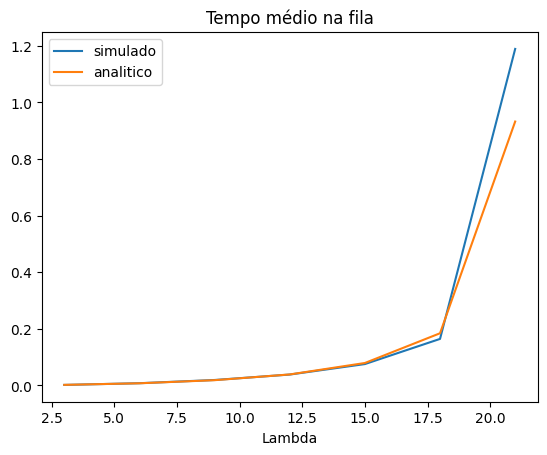

In [9]:
# Tempo médio na fila simulado vs analítico
fig, ax = plt.subplots()  # Cria figura com um único subplot (eixo ax)

# Plotar
#   Eixo x: LB
#   eixo y: s[0]    para dados simulados
#   eixo y: a[0]    para valores analíticos
ax.plot(LB, [s[0] for s in simulado], label='simulado');  # Plotar os dados
ax.plot(LB, [a[0] for a in analitico], label='analitico');  # Plotar os dados

# Título do gráfico
plt.title('Tempo médio na fila')

# Título do eixo x
plt.xlabel('Lambda')
plt.legend();

### Plotar gráfico do número médio de tarefas na fila em função dos valores de lambda
Dica: o número médio de tarefas na fila está na posição 3 dos arrays simulado e analitico

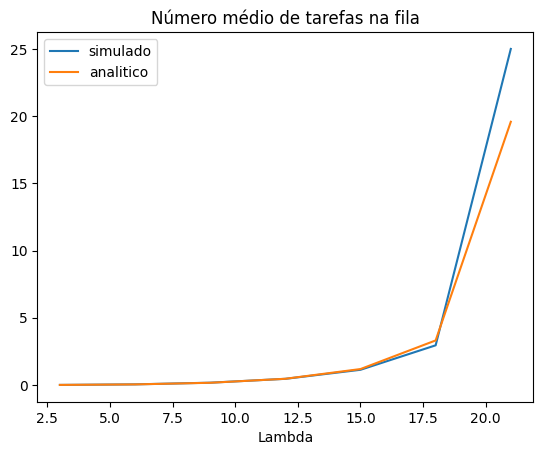

In [10]:

fig, ax = plt.subplots()


ax.plot(LB, [s[3] for s in simulado], label='simulado');
ax.plot(LB, [a[3] for a in analitico], label='analitico');

plt.title('Número médio de tarefas na fila')

plt.xlabel('Lambda')
plt.legend();

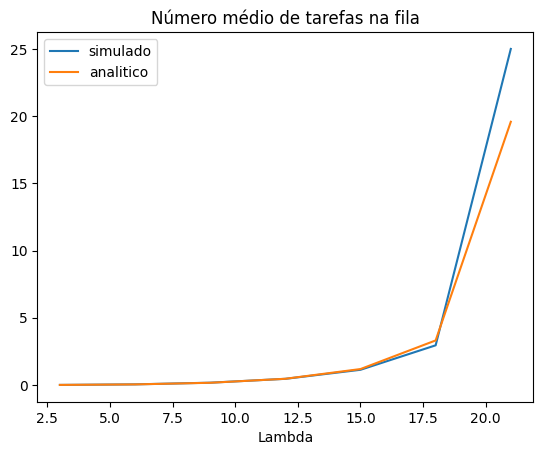

In [11]:

fig, ax = plt.subplots()


ax.plot(LB, [s[3] for s in simulado], label='simulado');
ax.plot(LB, [a[3] for a in analitico], label='analitico');

plt.title('Número médio de tarefas na fila')

plt.xlabel('Lambda')
plt.legend();

### Plotar gráfico do tempo médio de resposta em função dos valores de lambda
Dica: o tempo médio de resposta está na posição 2 dos arrays simulado e analitico

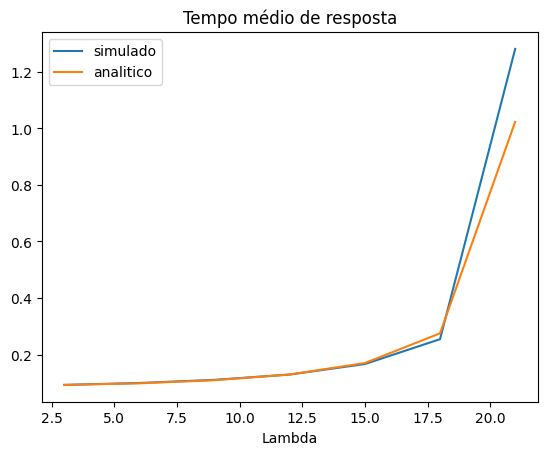

In [12]:


fig, ax = plt.subplots()


ax.plot(LB, [s[2] for s in simulado], label='simulado');
ax.plot(LB, [a[2] for a in analitico], label='analitico');

plt.title('Tempo médio de resposta')

plt.xlabel('Lambda')
plt.legend();

## Pergunta de desempenho
Muitos sistemas com fila apresentam uma curva de desempenho onde existe um ponto crítico, denominado joelho, a aprtir do qual o desempenho fica inaceitável. Responda a questão na célula abaixo.

In [ ]:
# Qual dos valores de carga (lambda) testados poderia ser considerado como limite máximo de carga de trabalho?
# Dica: maior valor de lambda anterior ao joelho
# Resposta: 15